In [24]:
#Author Tanmay

import pandas as pd
from gensim import corpora, models
import gensim
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import CoherenceModel
import string
from wordcloud import WordCloud

In [25]:
# List of your CSV files
csv_files = ['data1.csv', 'data2.csv', 'data3.csv', 'data4.csv', 'data5.csv', 'data6.csv', 'data7.csv', 'data8.csv']

# Initialize an empty list to store the DataFrames
dfs = []

# Iterate over the CSV files, read each into a DataFrame, and append to the list
for file_name in csv_files:
    df = pd.read_csv(file_name)
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [26]:
# Filter out rows where the "Comment" column is empty
combined_df = combined_df[combined_df['Comment'].notna() & (combined_df['Comment'] != '')]

In [27]:
# Define a function to concatenate unique values with a given separator
def unique_concat(series, separator=' | '):
    # Convert series to string to ensure .unique() and join() work correctly
    series_str = series.astype(str)
    return separator.join(series_str.unique())

# Aggregate the DataFrame by 'Author', applying the unique_concat function to 'Title' and 'Comment'
cleaned_data1 = combined_df.groupby('Author').agg({
    'Title': lambda x: unique_concat(x, ' | '),
    'Comment': lambda x: unique_concat(x, '\n\n')
}).reset_index()

cleaned_data1['text'] = cleaned_data1['Title'] + " " +  cleaned_data1['Comment']

cleaned_data1['text'] = cleaned_data1['text'].map(lambda x: x.lower())
#cleaned_data1['text'].to_csv('cleaneddata1.csv', index=False)

In [28]:
data = pd.read_csv('foodstamp_submissions_allyears.csv')

cleaned_data2 = data[
    ~data['selftext'].str.contains('\[deleted\]', case=False, na=False) &
    ~data['selftext'].str.contains('\[removed\]', case=False, na=False)
]

cleaned_data2['text'] = cleaned_data2['title'] + " " +  cleaned_data2['selftext']

# 3. Data Preprocessing
# Handle NaN values and ensure the data type is string
cleaned_data2['text'] = cleaned_data2['text'].fillna('')
#Removing any links
cleaned_data2['text'] = cleaned_data2['text'].str.replace(r'http\S+', '', regex=True)
# Remove punctuation, numbers, and special characters
cleaned_data2['clean_selftext'] = cleaned_data2['text'].map(lambda x: re.sub('[,\.!?]', '', x))
cleaned_data2['clean_selftext'] = cleaned_data2['clean_selftext'].map(lambda x: re.sub('\d+', '', x))
# Convert to lowercase
cleaned_data2['clean_selftext'] = cleaned_data2['clean_selftext'].map(lambda x: x.lower())

#cleaned_data2['clean_selftext'].to_csv('cleaneddata2.csv', index=False)



/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_2876/1949451165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data2['text'] = cleaned_data2['title'] + " " +  cleaned_data2['selftext']
/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_2876/1949451165.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data2['text'] = cleaned_data2['text'].fillna('')
/var/folders/5s/bzn_bky51k3bk9glk6bcxst40000gn/T/ipykernel_2876/1949451165.py:14: SettingWithCopyWarning: 
A value is 

In [31]:
# Extract the Series from each DataFrame
series1 = cleaned_data2['clean_selftext']
series2 = cleaned_data1['text']

# Concatenate the two Series into one
combined_series = pd.concat([series1, series2], ignore_index=True)

# Create a new DataFrame from the combined Series
new_df = pd.DataFrame(combined_series, columns=['data'])
print(new_df.size)

8761


In [21]:
# Remove stop words and perform lemmatization

# Add custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = ["i'm","im", "i've", "im", "ive","hi","etc","would","want"
,"get","Äôt","ampxb","thanks","i’m","got","th","irt","san","ca","u","cal","calfresh"
,"los","angeles","told","said","doesnt","s","k","&amp","#xb","snap","stamp","ohio"
,"alabama","still","know","like","ebt","please","people","california","change"
,"live","back","thing","need","last","food","stamp","it’s","don't","york"]

stop_words = stop_words.union(custom_stopwords)

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

clean_text = [clean(doc).split() for doc in new_df['data']]

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(clean_text)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_text]

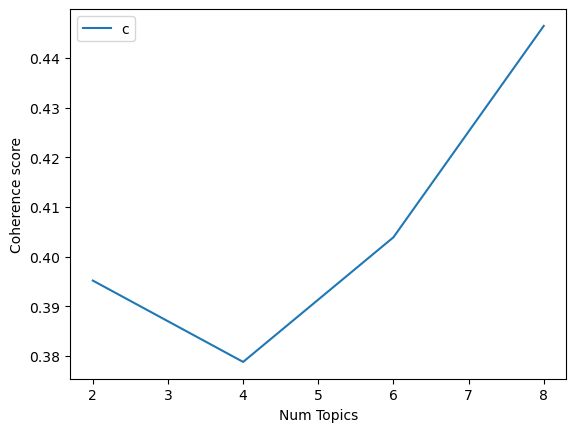

Num Topics = 2  has Coherence Value of 0.3952
Num Topics = 4  has Coherence Value of 0.3788
Num Topics = 6  has Coherence Value of 0.4039
Num Topics = 8  has Coherence Value of 0.4465


In [9]:
#Deciding on what value of num_topic to choose for the most optimal results
#No Need to run this as, num_topics = 8 performed the best
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        
        # Compute Coherence Score using c_v
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=clean_text, start=2, limit=10, step=2)

# Show graph
import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [22]:
# 4. LDA Modeling
# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)

In [23]:
# 5. Result Interpretation
# Print the topics and the weights of words
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.022*"income" + 0.015*"state" + 0.014*"work" + 0.011*"student" + 0.010*"program" + 0.009*"limit" + 0.009*"requirement" + 0.008*"benefit" + 0.008*"year" + 0.008*"household"')
(1, '0.020*"fraud" + 0.014*"investigator" + 0.012*"report" + 0.009*"investigation" + 0.007*"jail" + 0.007*"time" + 0.007*"louisiana" + 0.006*"file" + 0.006*"investigated" + 0.005*"name"')
(2, '0.015*"card" + 0.010*"use" + 0.010*"grocery" + 0.010*"store" + 0.009*"account" + 0.009*"state" + 0.008*"item" + 0.008*"buy" + 0.007*"walmart" + 0.006*"meal"')
(3, '0.038*"benefit" + 0.037*"month" + 0.024*"card" + 0.016*"amount" + 0.014*"anyone" + 0.013*"received" + 0.013*"approved" + 0.013*"balance" + 0.012*"deposit" + 0.010*"allotment"')
(4, '0.014*"stamp" + 0.013*"pay" + 0.010*"work" + 0.010*"help" + 0.010*"rent" + 0.009*"make" + 0.009*"month" + 0.009*"job" + 0.009*"time" + 0.009*"year"')
(5, '0.028*"form" + 0.013*"proof" + 0.009*"verification" + 0.008*"letter" + 0.008*"pay" + 0.008*"statement" + 0.008*"fill" + 0.007*